In [1]:
import numpy as np
import re
%reload_ext autoreload
%autoreload 2

# API Requests
import requests

# Request Wrangling
import os
from os.path import basename, exists
import json

# Data wrangling
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Machine learning model
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline

# Check work
from sklearn.utils.validation import check_is_fitted

from scryfall_api import ScryfallAPI, ScryfallDataWrangler

# Supress warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
scryfall = ScryfallAPI()

print(f"API Response type: {type(scryfall.response)}")
print(f"API Request status code: {scryfall.response.status_code}")

API Response type: <class 'requests.models.Response'>
API Request status code: 200


In [5]:
scryfall.get_dataset()

{'success': True,
 'message': "Existing file 'all-cards-20221226101507.json' is the most updated version."}

In [43]:
df = scryfall.wrangler.wrangle()

print(f"df shape: {df.shape}")
print()
print(df.info())
print()
df.head()

df shape: (25573, 46)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25573 entries, 268924 to 105289
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   released_at            25573 non-null  datetime64[ns]
 1   layout                 25573 non-null  object        
 2   cmc                    25573 non-null  float64       
 3   set_name               25573 non-null  object        
 4   set_type               25573 non-null  object        
 5   rarity                 25573 non-null  object        
 6   frame                  25573 non-null  object        
 7   booster                25573 non-null  bool          
 8   is_legendary           25573 non-null  bool          
 9   n_types                25573 non-null  int64         
 10  is_artifact            25573 non-null  bool          
 11  is_creature            25573 non-null  bool          
 12  is_enchantment         25573 no

,released_at,layout,cmc,set_name,set_type,rarity,frame,booster,is_legendary,n_types,...,brawl_legal,historicbrawl_legal,alchemy_legal,paupercommander_legal,duel_legal,oldschool_legal,premodern_legal,has_flavor_text,n_keywords,price_usd
268924,1993-08-05,normal,1.0,Limited Edition Alpha,core,common,1993,True,False,1,...,not_legal,not_legal,not_legal,legal,legal,legal,legal,False,1,39.01
188580,1993-08-05,normal,4.0,Limited Edition Alpha,core,uncommon,1993,True,False,1,...,not_legal,not_legal,not_legal,not_legal,legal,legal,legal,False,1,325.00
226097,1993-08-05,normal,1.0,Limited Edition Alpha,core,uncommon,1993,True,False,1,...,not_legal,not_legal,not_legal,not_legal,legal,legal,legal,False,1,89.99
134153,1993-08-05,normal,1.0,Limited Edition Alpha,core,uncommon,1993,True,False,1,...,not_legal,not_legal,not_legal,not_legal,legal,legal,legal,False,0,151.98
268187,1993-08-05,normal,4.0,Limited Edition Alpha,core,uncommon,1993,True,False,1,...,not_legal,not_legal,not_legal,not_legal,legal,legal,legal,False,0,180.99


In [69]:
df["price_usd"].describe()

count    25573.000000
mean         3.131846
std         30.861236
min          0.010000
25%          0.090000
50%          0.190000
75%          0.620000
max       3599.990000
Name: price_usd, dtype: float64

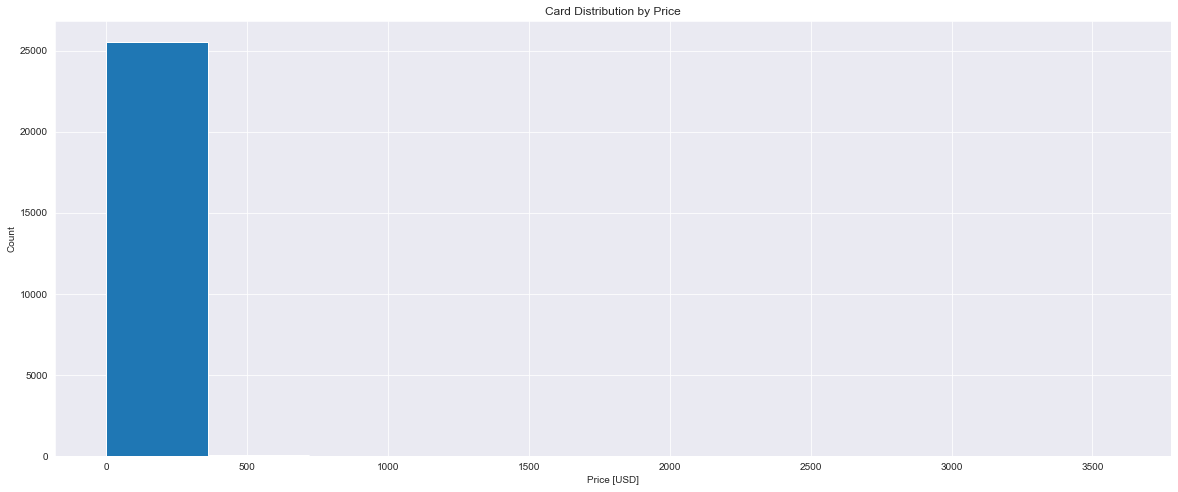

In [44]:
fig, ax = plt.subplots(figsize=(20, 8))

plt.hist(df["price_usd"])

plt.title("Card Distribution by Price")
plt.xlabel("Price [USD]")
plt.ylabel("Count");

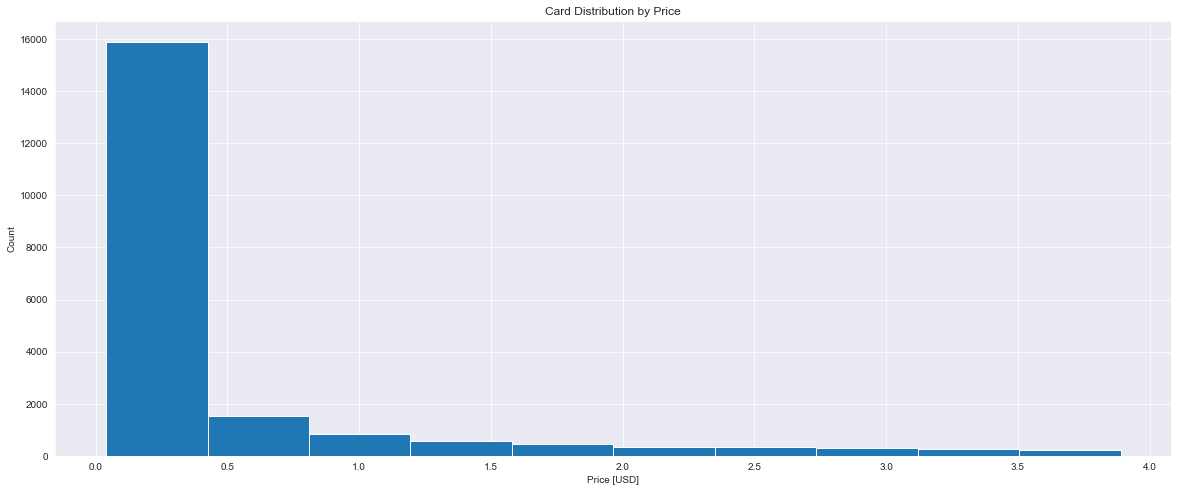

In [45]:
fig, ax = plt.subplots(figsize=(20, 8))

q1, q9 = df["price_usd"].quantile([0.1, 0.9])
mask = df["price_usd"].between(q1, q9)

plt.hist(df[mask]["price_usd"])

plt.title("Card Distribution by Price")
plt.xlabel("Price [USD]")
plt.ylabel("Count");

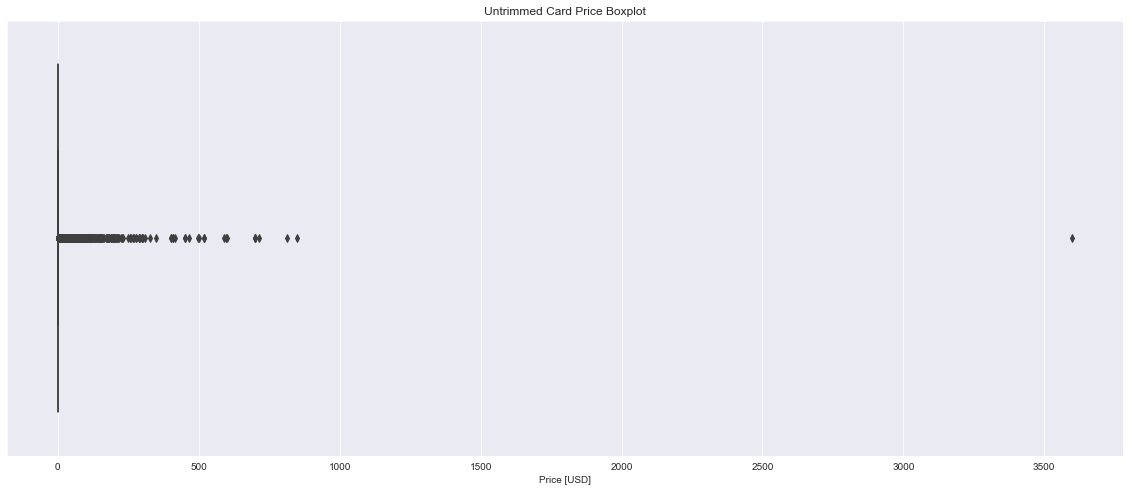

In [46]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.boxplot(x = "price_usd", data=df)

plt.title("Untrimmed Card Price Boxplot")
plt.xlabel("Price [USD]");

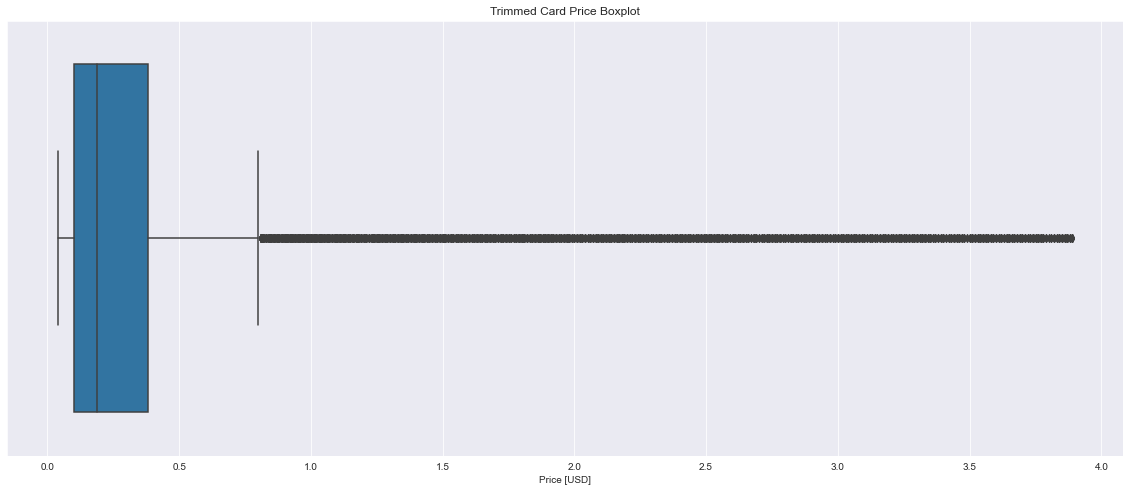

In [47]:
fig, ax = plt.subplots(figsize=(20, 8))

q1, q9 = df["price_usd"].quantile([0.1, 0.9])
mask = df["price_usd"].between(q1, q9)

sns.boxplot(x = "price_usd", data = df[mask])

plt.title("Trimmed Card Price Boxplot")
plt.xlabel("Price [USD]");

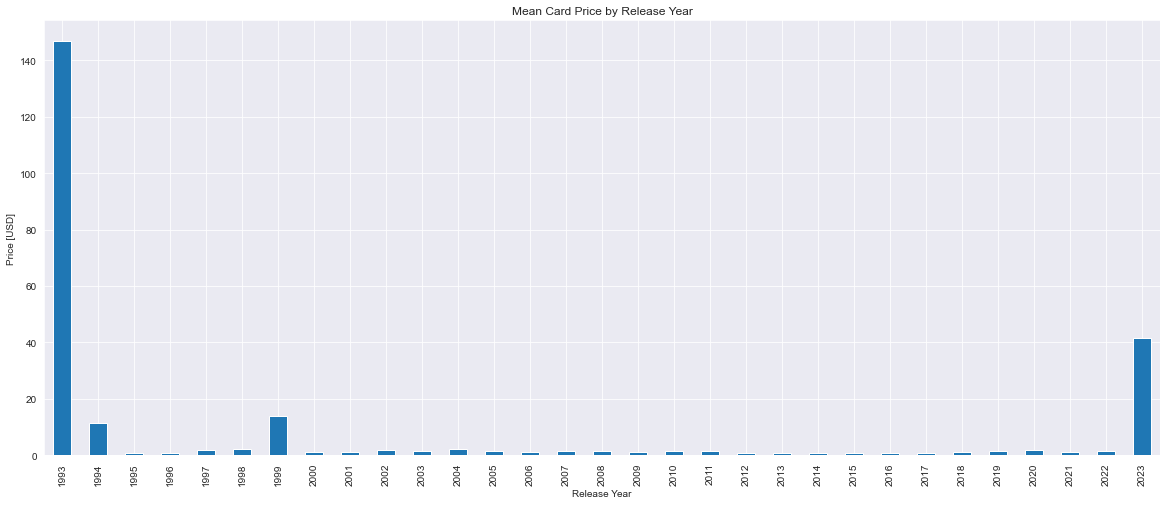

In [48]:
fig, ax = plt.subplots(figsize=(20, 8))

price_by_year = df.groupby(by=pd.DatetimeIndex(df['released_at']).year)
price_by_year["price_usd"].mean().plot(kind="bar", xlabel="Release Year", ylabel="Price [USD]", title="Mean Card Price by Release Year");

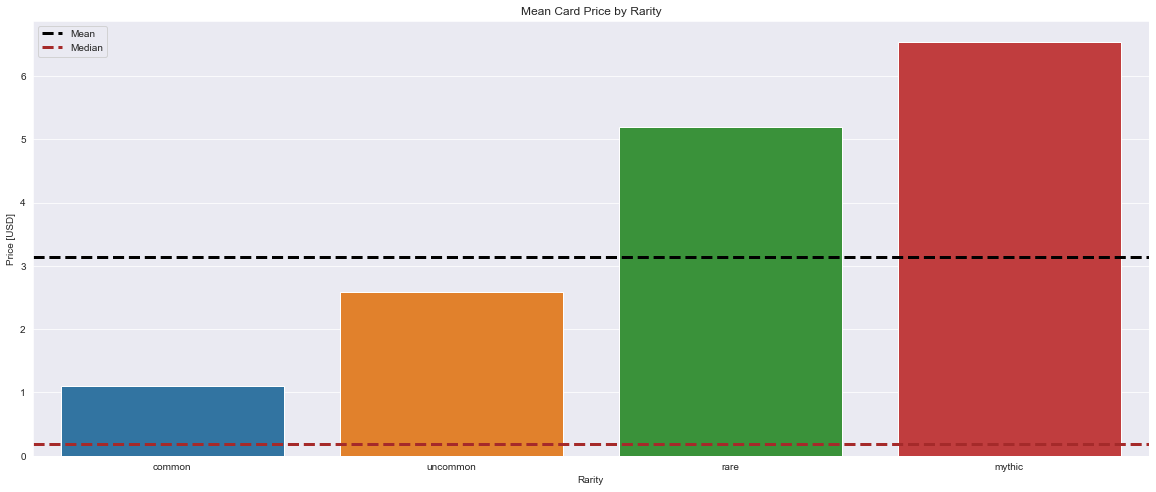

In [68]:
fig, ax = plt.subplots(figsize=(20, 8))

price_by_rarity = (
    df["price_usd"]
    .groupby(by = df["rarity"])
    .mean()
    .rename("mean_price")
    .to_frame()
    .reset_index()
)

sns.barplot(
    x="rarity",
    y="mean_price",
    data=price_by_rarity,
    order = {"0": "common", "1": "uncommon", "2": "rare", "3": "mythic"}.values()
)

plt.xlabel("Rarity")
plt.ylabel("Price [USD]")
plt.title("Mean Card Price by Rarity")\

plt.axhline(df["price_usd"].mean(), linestyle="--", linewidth=3, color="black", label="Mean")
plt.axhline(df["price_usd"].median(), linestyle="--", linewidth=3, color="brown", label="Median")
plt.legend();

# Machine Learning Price Predictor model for MTG cards

---
## 0. Untap - Project info

#### In this project, the goal is to take

#### Set restrictions:
#### <font color = "Green"> - Only non-online cards and sets will be analysed
#### - Sets that are comprised of masterpieces, Secret Lair Drops, Friday Night Magic Cards, Judge Gift promos and other exclusive, high-end or niche cards will not be analysed
#### <font color = "Green"> - Only cards that are not part of an "Un-" set will be analysed
#### - Retail price as specified by TCGPlayer
#### - Only the price of each card at the day of its respective set or product launch will be regarded
#### <font color = "Green"> - Only cards that aren't reprints will be analysed
#### <font color = "Green"> - Only cards that aren't tokens will be analysed
#### - Cards that are of the type Conspiracy, Emblem, Hero, Phenomenon, Plane, Scheme or Vanguard won't be analysed.
#### <font color = "Green"> - Basic Lands won't be analysed
#### <font color = "Green"> - Cards on The Reserved List won't be analysed
#### <font color = "Green"> - Oversized cards won't be analysed



---
## 1. Upkeep - Importing the Libraries

---
## 2. Draw - Importing the Data

---
## 3. First Main Phase - Treating df